In [1]:
## idea length of rivers per area for each county
import geopandas as gpd
from glob import glob
import osmnx as ox
from tqdm import tqdm
tqdm.pandas()
import cartopy.crs as ccrs
import h3pandas
import matplotlib.pyplot as plt
from jenkspy import JenksNaturalBreaks
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import pystac_client
import pandas as pd
import planetary_computer
import rioxarray as rio
from shapely import box

from rasterio.features import geometry_mask
import xarray as xr

plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
prj = ccrs.epsg(27700)
utmprj = ccrs.UTM(30)

# low res uk and ireland
b4326 = gpd.read_file('../day3_polygons/ne_10m_admin_0_countries.zip',
                      where="name in ('United Kingdom', 'Ireland')")
b = b4326.to_crs(prj)
bbuff = gpd.GeoDataFrame(geometry=b.buffer(50_000).to_crs(4326))

## fill buffered aoi with hexagons
hex_4326 = bbuff.h3.polyfill_resample(4).reset_index()

# reproject to osgb, then add column for orginal geometry (in lat,lon)
hex = hex_4326.to_crs(prj)
hex = hex.merge(hex_4326['geometry'].rename('geometry_4326'), left_index=True, right_index=True)
hex['bbox_4326'] = hex.apply(lambda q: box(*q['geometry_4326'].bounds),axis=1)

## only inc. hexagons that intersect country (i.e. ditch the oceans)
## and drop any duplicates
b_geom = b.dissolve()['geometry'][0]
hex = hex.loc[hex.intersects(b_geom)]
hex = hex.drop_duplicates(subset='h3_polyfill')

### river lengths

In [ ]:
def get_river_length(row):
    try:
        rivers = ox.features_from_polygon(row.geometry_4326, tags={'waterway':['river','stream']})
    except:
        print("didn't work")
        return -1
        
    return (rivers.to_crs(prj)
            .clip(row.geometry)
            .length
            .sum()/1000)

hex['river_length'] = hex.progress_apply(lambda q: get_river_length(q), axis=1)
hex_clipped = hex.clip(b)

In [ ]:
fig,ax=plt.subplots(figsize=[7,10], subplot_kw={'projection':utmprj})

hex_clipped.loc[hex['river_length']>-1].to_crs(utmprj).plot(column='river_length',
         ec='w',
         legend=False, 
         vmin=0,
         vmax=hex_clipped['river_length'].max(),
         cmap='Blues', ax=ax,) 

scatter = ax.collections[-1]

b.to_crs(utmprj).plot(fc='none', ec='k',linewidth=1, ax=ax)

minx,miny,maxx,maxy = hex.loc[hex['river_length']>-1].to_crs(utmprj).total_bounds
ax.set_xlim(minx,maxx)
ax.set_ylim(top=maxy)

ax.set_axis_off()

ax.annotate(text='Data from: Open Street Map & Natural Earth',
            xy=(1,0.01), 
            xycoords='axes fraction', 
            ha='right',
            c='k',
            fontsize=8,
            )

ax.annotate(text='by:tlohde',
            xy=(0.01,0.01), 
            xycoords='axes fraction',
            ha='left',
            c='k',
            fontsize=8,
            )

cb = plt.colorbar(scatter, ax=ax,
                  orientation='horizontal',
                  location='top',
                  shrink=0.7,
                  pad=-0.01,)
                #   label='river and stream length (km)')
cb.outline.set_visible(False)
fig.axes[-1].set_title('total river and stream length (km)')

# fig.savefig('day13_riversonly.png', bbox_inches='tight', dpi=300)

### topography
- wanted to to bivariate choropleth with one axes for length of stream network and another for some measure of topographic ruggedness...
- didn't make it happen
- following [this](https://github.com/OpenTopography/OT_BulkAccess_COGs/blob/main/OT_BulkAccessCOGs.ipynb) notebook

In [ ]:
## for masking cogs:
# https://github.com/corteva/rioxarray/issues/115
# https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile

def get_z_limits(row):
    from rioxarray.exceptions import OneDimensionalRaster
    import dask.array as da
    
    aoi = box(*row.geometry.bounds)
    
    ## get contours in aoi from copernicus global DEM hosted on planetary computer
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace)

    search = catalog.search(collections=['cop-dem-glo-30'],
                            intersects=aoi)
    items = list(search.items())
       
    if len(items) == 0:
        return (-9999,-9999,-9999,-9999,-9999)
    
    chunked_arrs=[] 
    for item in items:
        try:
            with rio.open_rasterio(
                item.assets['data'].href,
                chunks='auto',
                parse_coordinates=False
                ).rio.clip_box(*row.geometry.bounds) as ds:
                dimensions = dict(zip(ds.dims, ds.shape))
                
                geomask = geometry_mask([row.geometry],
                                        out_shape=(dimensions['y'], dimensions['x']),
                                        transform=ds.rio.transform(),
                                        invert=True)
            
                geomask = xr.DataArray(geomask, dims=['y','x'])
            
                masked = ds.where(geomask==True)[0,:,:]
                chunked_arrs.append(masked.data.flatten())
                
        except OneDimensionalRaster:
            print('oops: no bother though')
    
    arr = da.concatenate(chunked_arrs)
    
    return [da.nanmin(arr).compute(),
            da.nanmax(arr).compute(),
            da.nanmean(arr).compute(),
            da.nanstd(arr).compute(),
            da.nanvar(arr).compute()]
    

In [ ]:
hex_clipped['stats'] = (hex_clipped.to_crs(4326)).progress_apply(lambda row: get_z_limits(row), axis=1)

#### exporting to save re-running the above

# hex_clipped.to_feather('hex_with_river_and_zstats.feather')
# hex_clipped = gpd.read_feather('hex_with_river_and_zstats.feather')
# h = pd.merge(left=hex_clipped,
#              right=(hex_clipped['stats'].apply(pd.Series)).rename(columns=dict(zip([0,1,2,3,4],['min','max','mean','std','var']))),
#              left_index=True, right_index=True)
# h.to_feather('updated_hex.feather')

## plotting

In [27]:
# read in exported version
h = gpd.read_feather('updated_hex.feather')

In [32]:
## get natural breaks of river data
jnb = JenksNaturalBreaks(4)
jnb.fit(h['river_length'])

## map jenks breaks labels to letters
h['rivery'] = jnb.labels_
h['rivery'] = h['rivery'].map(dict(zip([0,1,2,3],['a','b','c','d'])))

# normalize the breaks and use this to index the colormaps
norm = Normalize(vmin=h['river_length'].min(),
                 vmax=h['river_length'].max())
river_c_index = [norm(q) for q in jnb.breaks_][0:-1]
blues = dict(zip(['a','b','c','d'],[get_cmap('Blues')(a) for a in river_c_index]))

### ditto for elevation standard deviation
jnb.fit(h['std'])
h['hilly'] = jnb.labels_
norm = Normalize(vmin=h['std'].min(),
                 vmax=h['std'].max())
hill_c_index = [norm(q) for q in jnb.breaks_][0:-1]
oranges = dict(zip([0,1,2,3],[get_cmap('Oranges')(a) for a in hill_c_index]))

## combine classes of rivers and hills
h['bi'] = h['rivery'].astype('str') + h['hilly'].astype('str')

## multiply each r,g,b,a channel from each pair of colours from the two colormaps
bivar = {}
for bidx,blu in blues.items():
    for oidx, ora in oranges.items():
        new_color =  [c1*c2 for c1,c2 in zip(blu, ora)]
        new_idx = str(bidx) + str(oidx)
        bivar[new_idx] = new_color

# add the colors to the data frame
h['color'] = h['bi'].map(bivar)

In [33]:
## madness for rotating the colorbar axes!
## from: https://matplotlib.org/stable/gallery/axisartist/demo_floating_axes.html
def setup_axes1(fig, rect):
    from matplotlib.transforms import Affine2D
    import mpl_toolkits.axisartist.floating_axes as floating_axes
    from mpl_toolkits.axisartist.grid_finder import MaxNLocator
    tr = Affine2D().scale(1, 1).rotate_deg(45)

    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 3.5, -0.5, 3.5),
        grid_locator1=MaxNLocator(nbins=4),
        grid_locator2=MaxNLocator(nbins=4))

    ax1 = fig.add_subplot(
        rect, axes_class=floating_axes.FloatingAxes, grid_helper=grid_helper)
        
    ax1.axis['left'].label.set_text('hilly')
    ax1.axis['bottom'].label.set_text('rivery')
    ax1.axis["left"].toggle(ticklabels=False, label=True)
    ax1.axis["bottom"].toggle(ticklabels=False, label=True)
    ax1.tick_params(colors='none')
    [ax1.axis[pos].line.set_visible(False) for pos in ['top','left','right','bottom']]
    
    aux_ax = ax1.get_aux_axes(tr)

    return ax1, aux_ax

Text(0.0, 0.93, 'rocks & water')

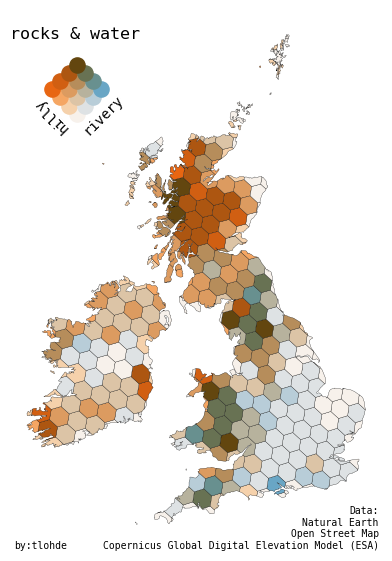

In [38]:

fig = plt.figure(figsize=[6,7])
ax = fig.add_subplot(111)
cax,ax1 = setup_axes1(fig,362)

h.plot(facecolor=h['color'], edgecolor='k', linewidth=0.2, ax=ax)
ax.set_axis_off()
ax.set_aspect('equal')

## plotting grid of dots for each class-pair
mapping = dict(zip(['a','b','c','d'],[0,1,2,3]))
pairs = [(mapping[s[0]], int(s[1])) for s in bivar.keys()]
[ax1.scatter(p[0],
             p[1],
             color=c,
             s=120) for p,c in dict(zip(pairs,
                                        bivar.values())).items()];
ax1.set_aspect('equal')

ax.annotate(text='Data:\nNatural Earth\nOpen Street Map\nCopernicus Global Digital Elevation Model (ESA)',
            xy=(0.99,0.0), 
            xycoords='axes fraction', 
            ha='right',
            c='k', 
            fontsize=7,
            font='DejaVu Sans Mono')

ax.annotate(text='by:tlohde',
            xy=(0.01,0.0), 
            xycoords='axes fraction',
            ha='left',
            fontsize=7,
            font='DejaVu Sans Mono');

ax.set_title('rocks & water', loc='left', y=0.93)

In [39]:
fig.savefig('day13.png', bbox_inches='tight', dpi=300)